In [414]:
%matplotlib inline
import numpy as np
from sklearn.metrics import get_scorer
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.datasets import fetch_20newsgroups

# Ennoncé
Le travail consiste à implémenter un algorithme d’active learning pour la classification de textes selon le pseudo-code
ci-dessous :

Input : ensemble de données étiquetées L, et ensemble de données non étiquetées U

Output : ensemble de données étiquetées L UNION U

Tant que U non vide
1. Entraîner un classifieur C (par exemple, un simple classifieur bayesien naif) en utilisant L
2. Utiliser C pour prédire les données U
3. Sélectionner dans U n instances et former un ensemble I contenant ces instances
4. Demander à l’expert d’étiqueter I
5. Faire L = L UNION I et U = U MOINS I
L’expert devra être simulé par le programme.

La technique de sélection utilisée au point 3 sera l'Uncertainty Sampling.
On utilisera les algorithmes de classification implémentés dans Scikit.

A chaque étape on affichera une métrique d’évaluation (utilisant les implémentation de Scikit).
Les données à utiliser sont :

le sous-ensemble NG5 du corpus NG20 accessible via Scikit.

NG5 comprend les classes :
'rec.motorcycles',
'rec.sport.baseball',
'comp.graphics',
'sci.space',
'talk.politics.mideast'

Le corpus Classic3 accessible à l’adresse :
https://mycloud.mi.parisdescartes.fr/s/HwpG4bmaRp3sSCC
ATTENTION : pour NG5, on utilisera l’option remove=('headers', 'footers', 'quotes') pour une évaluation plus réaliste

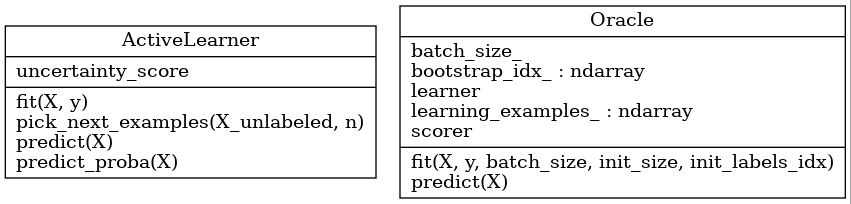

In [222]:

class ActiveLearner(): # could inherit from some scikit-learn class

    def __init__(self, clf,
                strategy='least_conf'):
        """
        Parameters:
        ----------
            clf : classifier, any classifier with a fit, predict, and predict_proba methods
                can be any scikit-learn classifier
            strategy : str, the querying strategy
                `'least_conf'`: least confidence query, the examples with the lowest max proba are chosen
                `'margin'` : margin query, the examples with the lowest difference
                            between most probable and second most probable are chosen
                `'entropy'` : entropy query, the examples with the highest entropy are chosen
        """
        super().__init__()
        self.learner = clf

        if strategy == 'least_conf':
            self.uncertainty_score = self._confidence_score
        elif strategy == 'margin':
            self.uncertainty_score = self._margin_score
        elif strategy == 'entropy':
            self.uncertainty_score = self._entropy_score
        else:
            raise ValueError(f"Unsupported querying strategy {strategy!r}")

    """Querying strategies"""
    def _confidence_score(self, probas):
        return np.max(probas)

    def _margin_score(self, probas):
        return [(x.sort(), x[-1]-x[-2])[1] for x in probas]

    def _entropy_score(self, probas):
        pass


    def pick_next_examples(self, X_unlabeled, n):
        """picks the examples it wants to learn from based on the query strategy
        Parameters:
        ----------
            X_unlabeled : np.ndarray, the unlabeled examples
            n : int, the number of examples to choose
        
        returns:
        -------
            the indices of the chosen examples
        """
        return np.argsort([self.uncertainty_score(x) for x in self.predict_proba(X_unlabeled)])[:n]
        #return np.argsort([self.uncertainty_score(self.predict_proba(x)) for x in X_unlabeled])[:n]

    def fit(self, X, y):
        return self.learner.fit(X, y)

    def predict(self, X):
        return self.learner.predict(X)
    
    def predict_proba(self, X):
        return self.learner.predict_proba(X)



In [396]:

class Oracle():
    """class that knows the labels and can tell them to the `ActiveLearner` when requested
    """
    def __init__(self, learner, metric='f1_macro'):
        """
        Parameters:
        ----------
            learner : the ActiveLearner to be trained
            metric : the metric that will be tracked,
                can be any valid scikit-learn metric 
        """
        self.learner = ActiveLearner(learner)
        self.scorer = get_scorer(metric)

    def fit(self, X, y, batch_size=None,
            init_size=None, init_labels_idx='random'):
        """train the `ActiveLearner` and keep track of the metrics
        Parameters:
        ----------
            X : np.ndarray, the attributes
            y : np.ndarray, the labels
            batch_size : int, the number of new examples at each iteration
            init_size : int, the number of initial examples the learner can receive
            init_labels : np.ndarray[int], the indices of the initial examples
        """
        
        self.batch_size_ = min(y.shape[0] * .1, 20) if batch_size == None else batch_size

        self.bootstrap_idx_ = np.zeros_like(y, dtype=bool)
        if init_labels_idx == 'random':
            init_size = min(y.shape[0] * .05, 30) if init_size == None else init_size
            init_labels_idx = np.random.choice(y.shape[0], size=init_size, replace=False)
        self.init_labels_idx=init_labels_idx
        self.bootstrap_idx_[init_labels_idx] = True
        self.learning_examples_ = self.bootstrap_idx_
        # TODO: learning loop
        # TODO: create variables and parameters for tracking the classes picked by the learner
        # TODO: define a stopping criterion. it could be user supplied
        self.label=np.unique(y)
        self.metrics=np.zeros(shape=(1,4,len(self.label)+1))
        self.models=[]
        i=0
        while not(np.sum(self.bootstrap_idx_)==len(self.bootstrap_idx_)):

            X_train=X[self.learning_examples_==True]
            X_test=X[self.learning_examples_==False]
            y_train=y[self.learning_examples_==True]
            y_test=y[self.learning_examples_==False]
            
            self.learner.fit(X_train, y_train)
            y_pred=self.learner.predict(X_test)
            score_total=np.array([precision_recall_fscore_support(y_test, y_pred, average='micro')])
            score_total.shape=(1,4,1)
            score_by_classes=np.array([precision_recall_fscore_support(y_test, y_pred, average=None,labels=self.label)])
            
            scores=np.dstack([score_by_classes, score_total])
            self.metrics=np.vstack([self.metrics, scores])
            self.models.append(self.learner)
            
            new_idx=self.learner.pick_next_examples(X_test, self.batch_size_)
            self.bootstrap_idx_[np.array([i for i, x in enumerate(self.learning_examples_) if x==False])[new_idx]] = True
            self.learning_examples_ = self.bootstrap_idx_
            
        self.metrics=self.metrics[1:,:,:]
            
    def predict(self, X):
        pass 

    # TODO: add methods for returning the tracked values


In [397]:
oracle=Oracle(clf)
oracle.fit(X_train_tfidf, ng5_train.target, batch_size=1000)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [231]:
categories = ['rec.motorcycles', 'rec.sport.baseball',
                'comp.graphics', 'sci.space',
                'talk.politics.mideast']
remove = ("headers", "footers", "quotes")
ng5_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
ng5_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

"""
[ (k,ng5_train[k]) for k in ng5_train ]
ng5_train.keys()   ==>  dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])
(ng5_train['data'][1])
"""

## Exploring Data ##
len(ng5_train.data)
len(ng5_test.target)

1954

In [232]:

## Create doc-term Matrix
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(ng5_train.data)
print(X_train_counts.shape)

## Transform it into frequency matrix aka tf-idf 
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

## Train a Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()#.fit(X_train_tfidf, ng5_train.target)

(2936, 33046)


In [379]:
print(ng5_train.target.shape)
print(np.unique(ng5_train.target))
print(np.unique(ng5_train.target).shape)
print(np.array(oracle.metrics).shape)
print(len(oracle.models))
#print(np.array(oracle.metrics))

(2936,)
[0 1 2 3 4]
(5,)
(3, 4, 6)
3


In [380]:
# 3 fits | 4 mesures | 5 classes

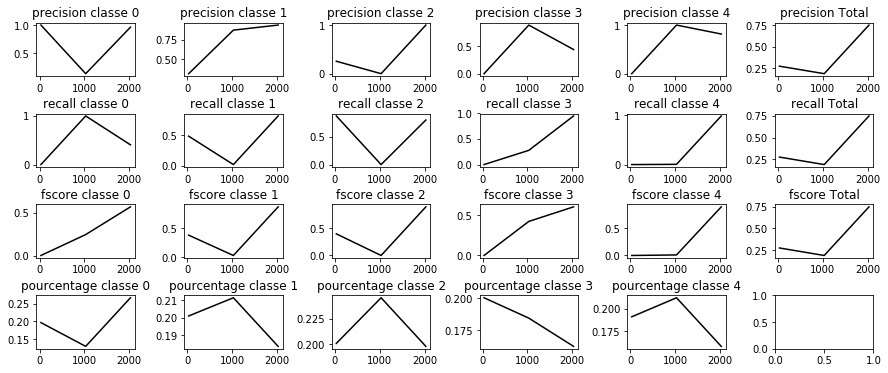

In [421]:
fig, axs = plt.subplots(np.array(oracle.metrics).shape[1], np.array(oracle.metrics).shape[2], figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .7, wspace=.5)

axs = axs.ravel()
for x in range(np.array(oracle.metrics).shape[1]):
    for y in range(np.array(oracle.metrics).shape[2]):
        if y==len(oracle.label):
            classe=" Total"
            if x==3:
                break
        else:
            classe=" classe "+str(oracle.label[y])
            
        if not(x==3):
            axs[(np.array(oracle.metrics).shape[2]*x)+y].plot(range(len(oracle.init_labels_idx), oracle.learning_examples_.shape[0], oracle.batch_size_), np.array(oracle.metrics)[:,x,y], color='black')
        else:
            axs[(np.array(oracle.metrics).shape[2]*x)+y].plot(range(len(oracle.init_labels_idx), oracle.learning_examples_.shape[0], oracle.batch_size_), [a/z for a, z in zip(np.array(oracle.metrics)[:,x,y], range(oracle.learning_examples_.shape[0], len(oracle.init_labels_idx), -oracle.batch_size_))], color='black')
        axs[(np.array(oracle.metrics).shape[2]*x)+y].set_title(["precision", "recall", "fscore", "pourcentage"][x]+classe)            


In [409]:
svd = TruncatedSVD (n_components=2)
X=svd.fit_transform(X_train_tfidf)
X_train, X_test, y_train, y_test = train_test_split( X, ng5_train.target, test_size=0.33, random_state=42)

X_trainc=svd.inverse_transform(X_train)
X_testc=svd.inverse_transform(X_test)
#X_trainc, X_testc, y_trainc, y_testc = train_test_split( X_train_tfidf, ng5_train.target, test_size=0.33, random_state=42)

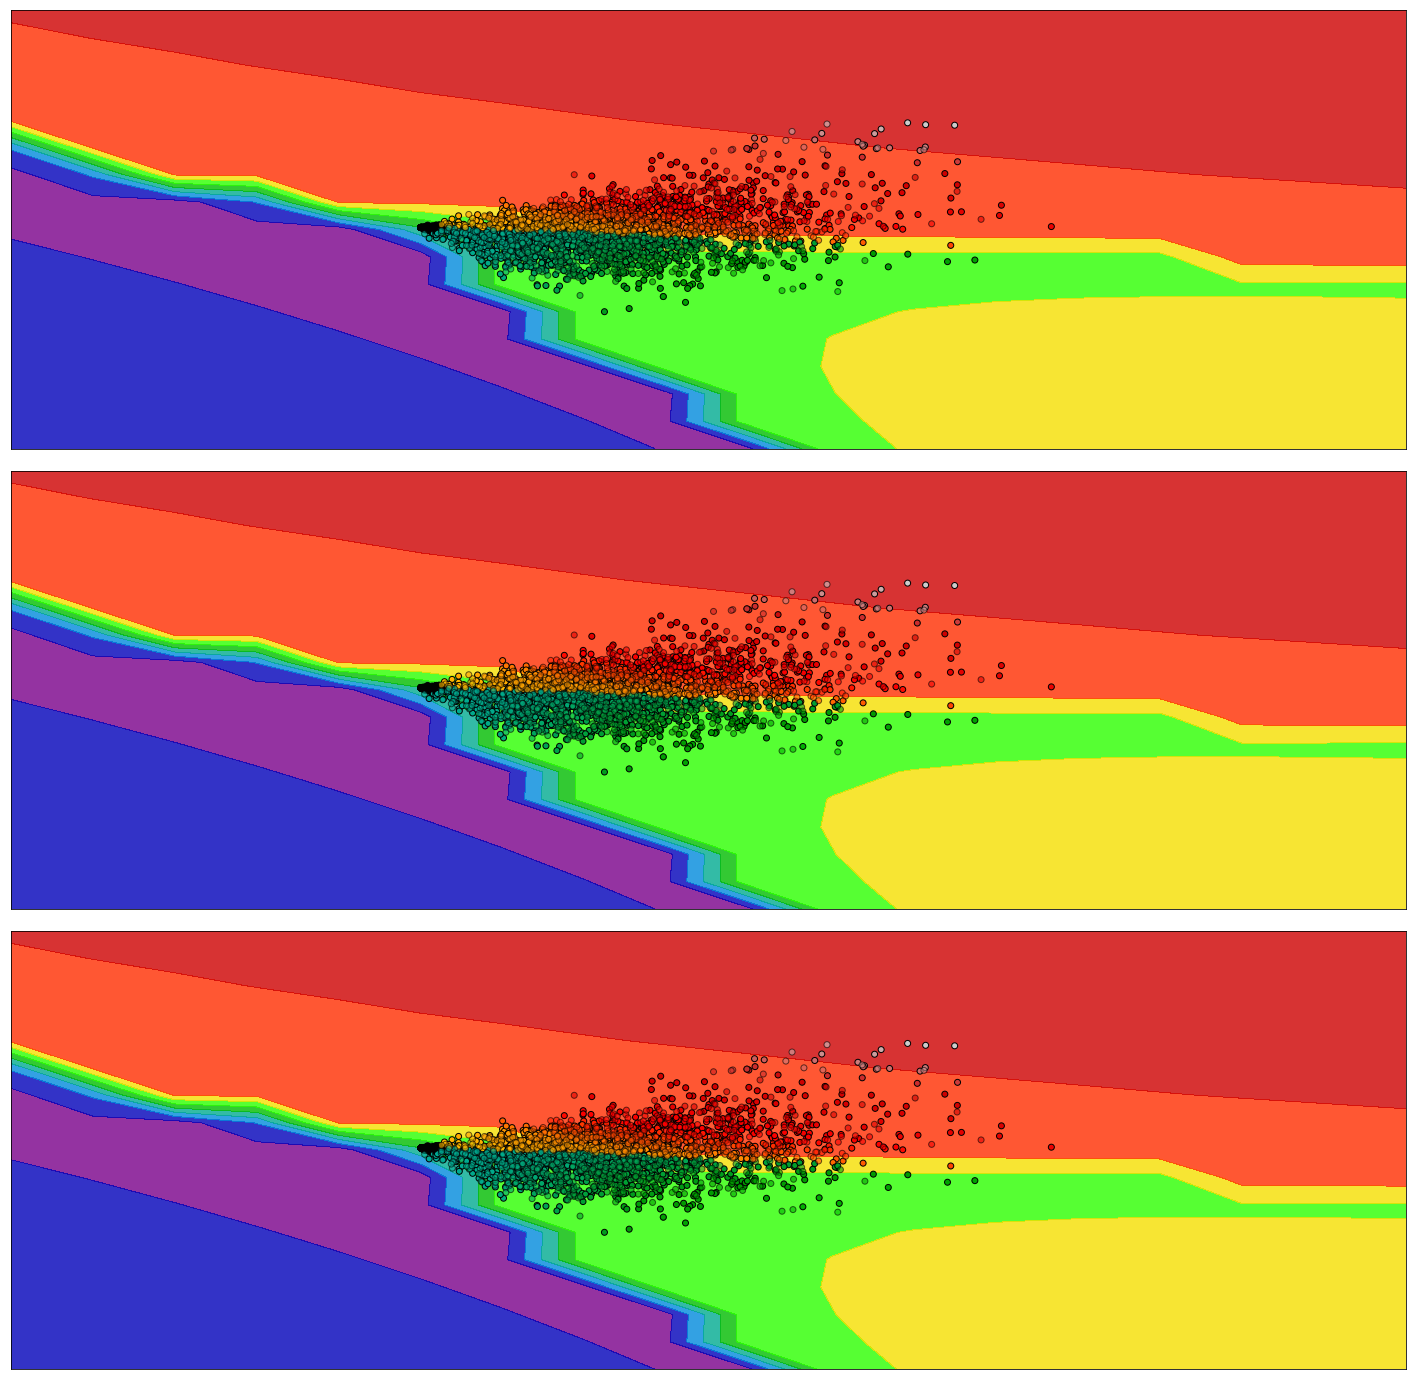

In [411]:
fig, axs = plt.subplots(len(oracle.models), 1, figsize=(25, 25), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .05, wspace=.5)

axs = axs.ravel()
h = .1  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
xxc=svd.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
for i in range(len(oracle.models)):
    cm = plt.cm.nipy_spectral
    
    #if hasattr(clf, "decision_function"):
    #    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    #else:
    Z = np.array([np.argmax(x)+np.max(x) for x in oracle.models[i].predict_proba(xxc)])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    axs[i].contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot the training points
    axs[i].scatter(X_train[:, 0], X_train[:, 1], c=[np.argmax(x)+np.max(x) for x in oracle.models[i].predict_proba(X_trainc)], cmap=cm,
               edgecolors='k')
    # Plot the testing points
    axs[i].scatter(X_test[:, 0], X_test[:, 1], c=[np.argmax(x)+np.max(x) for x in oracle.models[i].predict_proba(X_testc)], cmap=cm,
               edgecolors='k', alpha=0.6)

    axs[i].set_xlim(xx.min(), xx.max())
    axs[i].set_ylim(yy.min(), yy.max())
    axs[i].set_xticks(())
    axs[i].set_yticks(())
    #plt.tight_layout()
    #plt.show()